In [1]:
import matplotlib.pyplot as plt 

In [2]:
import torch
from torch import nn 
from torch.nn import functional as F
from torch import optim

In [3]:
from dlc_practical_prologue import generate_pair_sets

# Data
1,000 train and test pair sets

In [4]:
tr_inp, tr_bool, tr_digits, te_inp, te_bool, te_digits = generate_pair_sets(1000)

`tr_bool` is a 0 or 1 where 1 indicates that the <b>first</b> image is lesser or equal to the second.
`tr_digits` are tuples of the digits of the two images.

In [5]:
def normalize(tr_inp, te_inp):
    mean = torch.mean(tr_inp)
    std = torch.std(tr_inp)
    tr_inp -= mean 
    tr_inp /= mean 
    te_inp -= mean 
    te_inp /= mean 
    return tr_inp, te_inp 

In [6]:
# normalise data 
tr_inp, te_inp = normalize(tr_inp, te_inp)

In [7]:
torch.mean(tr_inp)

tensor(2.4912e-09)

In [8]:
torch.bincount(tr_bool)

tensor([478, 522])

In [9]:
# maybe fix class imbalance 

## Visualise data

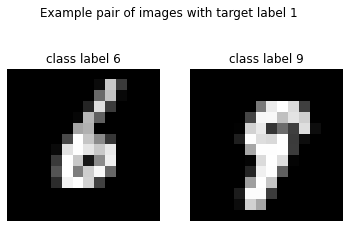

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.suptitle("Example pair of images with target label {}".format(tr_bool[0]))

for i in range(2):
    axes[i].imshow(tr_inp[0][i], cmap="gray")
    axes[i].set_axis_off()
    axes[i].set_title('class label {}'.format(tr_digits[0][i]))

plt.show()

# Models
Remember for the models below all accuracies need to be 10-fold validated.


## Baseline LeNet

In [11]:
# can try diff activation functions but for now using relu 

In [12]:
# also try dropout layers

In [13]:
class BaseNet(nn.Module):
    def __init__(self, inp_channels=2, out_channels=2, n_hidden=50):
        super().__init__()
        self.conv1 = nn.Conv2d(inp_channels, 32, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.dropout = nn.Dropout(p=0.25)
       # self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64, n_hidden)
        self.fc2 = nn.Linear(n_hidden, out_channels)

    def forward(self, x):
        # CONV LAYER 1
        x = F.relu(self.pool1(self.conv1(x)))

        # CONV LAYER 2
        x = F.relu(self.conv2(x))
      #  x = F.relu(self.pool2(x))

        # RESHAPE 
        x = x.view(x.size(0), -1)
       # print('shape after reshaping', x.shape)

        # FC 1
        x = F.relu(self.fc1(x))

       # x = self.dropout(x)
        # FC2
        x = self.fc2(x)
      #  print('shape after fc2', x.shape)
        return x

In [14]:
def train_model(model, criterion, tr_inp, tr_target, mini_batch_size, 
                optimizer, nb_epochs, verbose=False): 
    losses = torch.zeros(nb_epochs) 
    train_accuracy = torch.zeros(nb_epochs) 
    
    for i in range(nb_epochs):
        loss_epoch = 0 
        correct_epoch = 0 

        for b in range(0, tr_inp.size(0), mini_batch_size):
            tr_inp_chunk = tr_inp.narrow(0, b, mini_batch_size) 
            tr_target_chunk = tr_target.narrow(0, b, mini_batch_size) 
            output = model(tr_inp_chunk) 
            loss = criterion(output, tr_target_chunk)
            loss_epoch += loss.item()

            label = torch.argmax(output, dim=1)
            true_label = tr_target_chunk 
            correct_epoch += (label == true_label).sum().item()

            model.zero_grad()
            loss.backward()
            optimizer.step()

        train_accuracy_i = correct_epoch / tr_target.size(0)
        train_accuracy[i] = train_accuracy_i
        losses[i] = loss_epoch 

        if verbose: 
            print('epoch', e) 
            print('loss', loss_epoch)
            print('train accuracy', train_accuracy_i)

    return model, losses, train_accuracy

In [15]:
def compute_class_accuracy(model, te_inp, te_target, mini_batch_size):
    incorrect = 0 

    for b in range(0, te_inp.size(0), mini_batch_size):
        pred = model(te_inp.narrow(0, b, mini_batch_size))
        label = torch.argmax(pred, dim=1)

        true_label = te_target.narrow(0, b, mini_batch_size)

        incorrect += torch.count_nonzero(true_label - label)

    acc = 1 - incorrect / te_target.size(0)
    return acc 

### Set params

In [16]:
criterion = nn.CrossEntropyLoss()

In [17]:
mini_batch_size = 10

In [18]:
nb_epochs = 25

In [19]:
eta = 1e-2

### Predicting boolean 0/1

In [20]:
model = BaseNet(inp_channels=2, out_channels=2)

In [21]:
optimizer = optim.Adam(model.parameters(), lr=eta)

In [22]:
# mess around with optimiser params
# also try decaying learning rate

In [23]:
model, losses, tr_acc = train_model(model, criterion, tr_inp, tr_bool,
                    mini_batch_size, optimizer, nb_epochs)

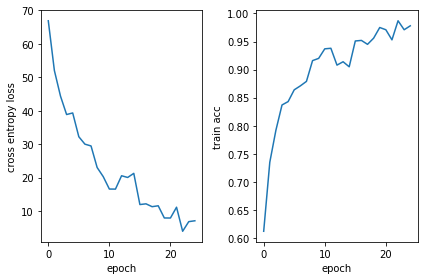

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(list(range(len(losses))), losses)
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("cross entropy loss")
ax[1].plot(list(range(len(losses))), tr_acc)
ax[1].set_xlabel('epoch')
ax[1].set_ylabel("train acc")
plt.tight_layout()
plt.show()

In [25]:
te_acc = compute_class_accuracy(model, te_inp, te_bool, mini_batch_size)

In [26]:
te_acc

tensor(0.7920)

In [27]:
# to 10-fold validate

## Weight sharing 
Here we can take advantage of the fact that we not only have the labels 0/1 but also the actual digits of both of the images. We share weights in a siamese network.

In [28]:
class SiameseNet(nn.Module):
    def __init__(self, inp_channels, class_channels, digit_channels, 
                 n_hidden=50):
        super().__init__()
        self.conv1 = nn.Conv2d(inp_channels // 2, 32, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.dropout = nn.Dropout(p=0.25)
       # self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64, n_hidden)
        self.fc2 = nn.Linear(n_hidden, digit_channels)

    def forward(self, x):
        # separate digits
        x1 = x[:, 0, :, :].view(-1, 1, 14, 14)
        x2 = x[:, 1, :, :].view(-1, 1, 14, 14)
        
        # predicted digits 
        with torch.no_grad():
            final_xs = torch.zeros(2, 10)
        
        for i, x in enumerate([x1, x2]):
           # print('init shape', x.shape)
            # CONV LAYER 1
            x = F.relu(self.pool1(self.conv1(x)))
           # print('shape after first layer', x.shape)

            # CONV LAYER 2
            x = F.relu(self.conv2(x))
            #print('shape after second layer', x.shape)
            #  x = F.relu(self.pool2(x))

            # RESHAPE 
            x = x.view(x.size(0), -1)
            #print('shape after reshaping', x.shape)

            # FC 1
            x = F.relu(self.fc1(x))
           # print('shape after first fc', x.shape)

            # x = self.dropout(x)
            # FC2
            x = self.fc2(x)
           # print('shape after second fc', x.shape)
            
            # right now this is the digit  
            with torch.no_grad():
                # this screws up the backprop
                _, x = torch.max(x, 1)
                final_xs[i] = x
        
        # compare digits to get class 
        with torch.no_grad():
            x = (final_xs[0] <= final_xs[1]).float().long()

        return x

In [29]:
def reshape_1d(inp):
    inp = inp.long()
    out = torch.zeros(2, inp.shape[0])
    out[0] = torch.where(inp==0, 1, 0)
    out[1] = torch.where(inp==1, 1, 0)
    # first zeros then ones
    # reshape for cross entropy loss
    return out.t()

In [30]:
model = SiameseNet(2, 2, 10)

In [31]:
optimizer = optim.Adam(model.parameters(), lr=eta)

In [32]:
criterion = nn.CrossEntropyLoss()

In [33]:
def train_siamese_model(model, criterion, tr_inp, tr_target, mini_batch_size, 
                optimizer, nb_epochs, verbose=False): 
    losses = torch.zeros(nb_epochs) 
    train_accuracy = torch.zeros(nb_epochs) 
    
    for i in range(nb_epochs):
        loss_epoch = 0 
        correct_epoch = 0 

        for b in range(0, tr_inp.size(0), mini_batch_size):
            tr_inp_chunk = tr_inp.narrow(0, b, mini_batch_size)
            tr_target_chunk = tr_target.narrow(0, b, mini_batch_size)
            output = model(tr_inp_chunk) 
            
            # reshape for loss 
            output_ = reshape_1d(output)
            
            loss = criterion(output_, tr_target_chunk)
            loss.requires_grad = True 
            loss_epoch += loss.item()
                
            n_correct = (output == tr_target_chunk).sum().item()
            correct_epoch += n_correct

            model.zero_grad()
            loss.backward()
            optimizer.step()

        train_accuracy_i = correct_epoch / tr_target.size(0)
        train_accuracy[i] = train_accuracy_i
        losses[i] = loss_epoch 

        if verbose: 
            print('epoch', e) 
            print('loss', loss_epoch)
            print('train accuracy', train_accuracy_i)

    return model, losses, train_accuracy

In [34]:
model, losses, tr_acc = train_siamese_model(model, criterion, tr_inp, tr_bool,
                    mini_batch_size, optimizer, nb_epochs)

In [35]:
# BUG !!! 

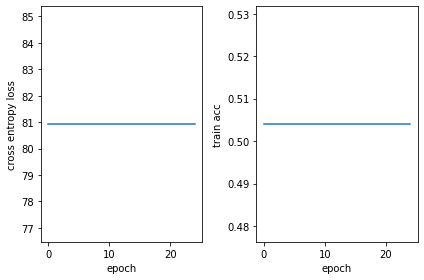

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(list(range(len(losses))), losses)
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("cross entropy loss")
ax[1].plot(list(range(len(losses))), tr_acc)
ax[1].set_xlabel('epoch')
ax[1].set_ylabel("train acc")
plt.tight_layout()
plt.show()

In [37]:
def compute_siamese_class_accuracy(model, te_inp, te_target, mini_batch_size):
    incorrect = 0 

    for b in range(0, te_inp.size(0), mini_batch_size):
        pred = model(te_inp.narrow(0, b, mini_batch_size))
        true_label = te_target.narrow(0, b, mini_batch_size)

        incorrect += torch.count_nonzero(true_label - pred)

    acc = 1 - incorrect / te_target.size(0)
    return acc 

In [38]:
te_acc = compute_siamese_class_accuracy(model, te_inp, te_bool, mini_batch_size)

In [39]:
te_acc

tensor(0.5190)